## '한국 복지 패널 데이터'를 이용한 데이터 분석
### 연령대 및 종교 유무에 따른 이혼율 분석하기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'figure.figsize': "8, 6"})
plt.rcParams.update({'font.family' : 'Malgun Gothic'})

pd.set_option('display.max_rows', 100)     # 행은 최대 100까지 출력
pd.set_option('display.max_columns', None) # 열은 무제한 출력

raw = pd.read_spss('./Koweps_hpwc17_2022_beta1.sav');
print(type(raw))

# 1~17차 머지데이터_변수명.xlsx
raw=raw.rename(
columns={'h17_g3'     : 'gender',         #  성별, 1: 남, 2: 여
         'h17_g4'     : 'birth',          #  태어난 연도
         'h17_g10'    : 'marriage_type',  #  혼인 상태
         'h17_g11'    : 'religion',       #  종교, 1: 있음, 2: 없음
         'p1702_8aq1' : 'income',         #  일한달의 월 평균 임금 
         'h17_eco9'   : 'code_job',       #  직업 코드
         'h17_reg7'   : 'code_region'})   #  7개 권역별 지역구분

# 직종 코드 확인
# list_job=pd.read_excel('./Koweps_Codebook_2022.xlsx', sheet_name='직종코드')
# print(type(list_job))
# print(list_job.head(5))

# 직종의 merge
# raw=raw.merge(list_job, how='left', on='code_job')
# raw[['code_job', 'job']].head(5)

# 성별 변경
# raw['gender'] = np.where(raw['gender'] == 1, 'male', 'female')
# raw['gender'].head(3)

# 연령
raw=raw.assign(age=((2023-raw['birth']))) # 만나이

# 연령대 파생 변수 제작
# age < 30: young, age < 60: middle, old
raw=raw.assign(ageg=np.where(raw['age'] < 30, 'young', np.where(raw['age'] < 60, 'middle', 'old')))

# marriage 파생 변수 제작
# 1: 유배우, 3: 이혼 -> 1: marriage, 2: divorce, 3: etc
def marrage(x):
    sw=''
    if x==1:
        sw='marriage'
    elif x==3:
        sw='divorce'
    else:
        sw='etc'
        
    return sw

raw['marriage']=raw['marriage_type'].apply(marrage)

plt.rcParams.update({'figure.figsize': "6, 4"})
plt.rcParams.update({'font.family' : 'Malgun Gothic'})

<class 'pandas.core.frame.DataFrame'>


In [2]:
df=raw.copy()
df['religion'] = np.where(df['religion']==1, 'yes', 'no')

In [3]:
df=df[['ageg', 'religion', 'marriage']]
df.head(3)

,ageg,religion,marriage
0,old,yes,etc
1,old,no,etc
2,old,yes,divorce


In [4]:
# etc 제외
df=df.query('marriage != "etc"')
df.head(3)

,ageg,religion,marriage
2,old,yes,divorce
3,old,yes,marriage
4,old,yes,marriage


In [5]:
df['ageg'].value_counts()

ageg
old       5378
middle    3962
young       53
Name: count, dtype: int64

In [6]:
df=df.query('ageg != "young"') # young 제외
df.head(3)

,ageg,religion,marriage
2,old,yes,divorce
3,old,yes,marriage
4,old,yes,marriage


In [7]:
# 연령대 및 종교 유무에 따른 이혼율 분석하기
df2=df.groupby(['ageg', 'religion', 'marriage'], as_index=False)['marriage'].size()
df2

,ageg,religion,marriage,size
0,middle,no,divorce,236
1,middle,no,marriage,2206
2,middle,yes,divorce,127
3,middle,yes,marriage,1393
4,old,no,divorce,266
5,old,no,marriage,2240
6,old,yes,divorce,260
7,old,yes,marriage,2612


In [24]:
# 연령대 및 종교 유무에 따른 이혼율 분석하기
df2=df.groupby(['ageg', 'religion', 'marriage'], as_index=True)['marriage'].size()
df2 # 이혼률을 구하기위하여 4개의 total 변수가 필요함.

ageg    religion  marriage
middle  no        divorce      236
                  marriage    2206
        yes       divorce      127
                  marriage    1393
old     no        divorce      266
                  marriage    2240
        yes       divorce      260
                  marriage    2612
Name: marriage, dtype: int64

In [47]:
# lambda 함수를 이용한 비율 계산
# level=[0]: ageg, index의 깊이, 0: ageg, 1: religion
# 1번 index인 religion는 집계용으로 사용됨, lambda 함수의 x 변수 값으로 할당됨.
df3=round(df2.groupby(level=[0]).apply(lambda x: x/x.sum()), 3)*100
print(type(df3))
print(df3)

<class 'pandas.core.series.Series'>
ageg    ageg    religion  marriage
middle  middle  no        divorce      6.0
                          marriage    55.7
                yes       divorce      3.2
                          marriage    35.2
old     old     no        divorce      4.9
                          marriage    41.7
                yes       divorce      4.8
                          marriage    48.6
Name: marriage, dtype: float64


In [41]:
df3.index # index가 여러개로 구성된 버그 확인, 'ageg', 'ageg', 'religion', 'marriage'

MultiIndex([('middle', 'middle',  'no',  'divorce'),
            ('middle', 'middle',  'no', 'marriage'),
            ('middle', 'middle', 'yes',  'divorce'),
            ('middle', 'middle', 'yes', 'marriage'),
            (   'old',    'old',  'no',  'divorce'),
            (   'old',    'old',  'no', 'marriage'),
            (   'old',    'old', 'yes',  'divorce'),
            (   'old',    'old', 'yes', 'marriage')],
           names=['ageg', 'ageg', 'religion', 'marriage'])

In [43]:
# level 0: ageg
# level 1: religion
# level 2: ageg
# level 3: religion
df3.droplevel(axis=0, level=0) # 첫번째 multi index level 삭제

ageg    religion  marriage
middle  no        divorce      6.0
                  marriage    55.7
        yes       divorce      3.2
                  marriage    35.2
old     no        divorce      4.9
                  marriage    41.7
        yes       divorce      4.8
                  marriage    48.6
Name: marriage, dtype: float64

In [48]:
# lambda 함수를 이용한 비율 계산
# level=[0, 1]: index의 깊이, 0: ageg, 1: religion
# 2번 index인 marriage는 집계용으로 사용됨, lambda 함수의 x 변수 값으로 할당됨.
df3=round(df2.groupby(level=[0, 1]).apply(lambda x: x/x.sum()), 3)*100
# print(type(df3))
print(df3)

ageg    religion  ageg    religion  marriage
middle  no        middle  no        divorce      9.7
                                    marriage    90.3
        yes       middle  yes       divorce      8.4
                                    marriage    91.6
old     no        old     no        divorce     10.6
                                    marriage    89.4
        yes       old     yes       divorce      9.1
                                    marriage    90.9
Name: marriage, dtype: float64


In [49]:
# level 0: ageg
# level 1: religion
# level 2: ageg
# level 3: religion
# level 4: marriage
# multi index level 0, 1 delete
df3 = df3.droplevel(axis=0, level=[0, 1])
df3

ageg    religion  marriage
middle  no        divorce      9.7
                  marriage    90.3
        yes       divorce      8.4
                  marriage    91.6
old     no        divorce     10.6
                  marriage    89.4
        yes       divorce      9.1
                  marriage    90.9
Name: marriage, dtype: float64

In [50]:
# reset_index(): index -> column
df4=pd.DataFrame(df3).rename(columns={'marriage': 'proportion'}).reset_index()
df4

,ageg,religion,marriage,proportion
0,middle,no,divorce,9.7
1,middle,no,marriage,90.3
2,middle,yes,divorce,8.4
3,middle,yes,marriage,91.6
4,old,no,divorce,10.6
5,old,no,marriage,89.4
6,old,yes,divorce,9.1
7,old,yes,marriage,90.9


In [51]:
df4=df4.query('marriage=="divorce"')
df4

,ageg,religion,marriage,proportion
0,middle,no,divorce,9.7
2,middle,yes,divorce,8.4
4,old,no,divorce,10.6
6,old,yes,divorce,9.1


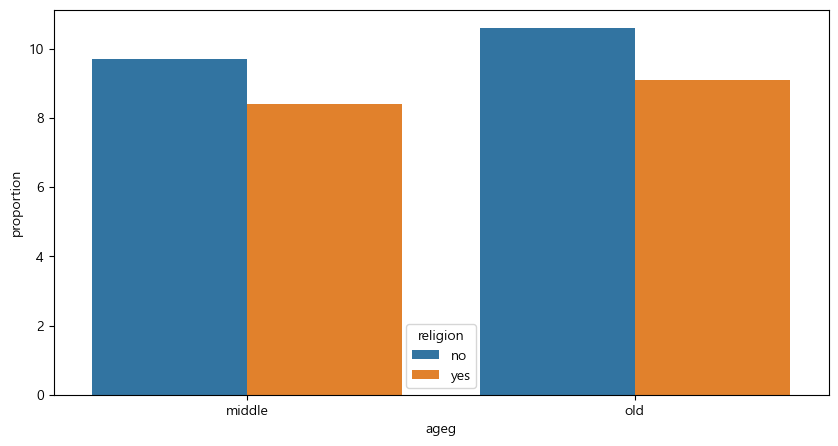

In [53]:
plt.rcParams.update({'figure.figsize': "10, 5"})
sns.barplot(data=df4, y='proportion', x='ageg', hue='religion');
# old로 갈수록 종교가 있는 사람과 없는 사람의 이혼률의 차이가 커진다.